# California County AQI Project

The purpose of this project is to create a general forecasting model that can be used to forecast any county in California.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import metrics

## Import Dataset

In [2]:
df = pd.read_csv("California_AQI_Dataset.csv", delimiter = "|")
df.head()

,Code,County,State,# Days with AQI,Good,Moderate,Unhealthy for Sensitive Groups,Unhealthy,Very Unhealthy,Hazardous,AQI Maximum,AQI 90th Percentile,AQI Median,# Days CO,# Days NO2,# Days O3,# Days PM2.5,# Days PM10,Year
0,6001,Alameda,CA,365,242,95,23,4,1,0,205,90.0,43.0,20,222,123,0,0,1981-12-31
1,6007,Butte,CA,365,293,71,1,0,0,0,126,67.0,33.0,69,131,165,0,0,1981-12-31
2,6011,Colusa,CA,320,228,55,37,0,0,0,150,101.0,35.0,0,0,320,0,0,1981-12-31
3,6013,Contra Costa,CA,365,248,88,21,8,0,0,179,90.0,44.0,23,160,182,0,0,1981-12-31
4,6017,El Dorado,CA,365,77,237,42,9,0,0,200,106.0,71.0,278,1,86,0,0,1981-12-31


## Preprocessing

In [3]:
#Select only the relevant rows
df = df.loc[:,["County","Year","AQI Median"]]
df

,County,Year,AQI Median
0,Alameda,1981-12-31,43.0
1,Butte,1981-12-31,33.0
2,Colusa,1981-12-31,35.0
3,Contra Costa,1981-12-31,44.0
4,El Dorado,1981-12-31,71.0
...,...,...,...
2162,Trinity,2022-12-31,23.0
2163,Tulare,2022-12-31,77.0
2164,Tuolumne,2022-12-31,39.0
2165,Ventura,2022-12-31,49.0


In [4]:
#Convert column into datetime
df["Year"] = pd.to_datetime(df["Year"], format = "%Y-%m-%d")

In [5]:
#Convert column into float
df["AQI Median"] = df["AQI Median"].astype("float64")

In [6]:
#View the total number of entries per county
df["County"].value_counts()

Alameda            42
Santa Cruz         42
San Bernardino     42
San Diego          42
San Francisco      42
San Joaquin        42
San Luis Obispo    42
Butte              42
Santa Barbara      42
Santa Clara        42
Shasta             42
Sacramento         42
Siskiyou           42
Solano             42
Sonoma             42
Stanislaus         42
Sutter             42
Tulare             42
Ventura            42
Yolo               42
San Benito         42
San Mateo          42
Riverside          42
Lake               42
Colusa             42
Contra Costa       42
Placer             42
El Dorado          42
Fresno             42
Glenn              42
Imperial           42
Kings              42
Kern               42
Los Angeles        42
Marin              42
Mendocino          42
Mono               42
Monterey           42
Orange             42
Napa               41
Merced             39
Inyo               38
Madera             38
Tehama             37
Mariposa           37
Plumas    

In [7]:
#Remove counties with entries below 42 to keep dataset uniform
filtered_df = df.groupby("County").filter(lambda x: len(x) == 42)
filtered_df["County"].value_counts()

Alameda            42
Santa Cruz         42
San Diego          42
San Francisco      42
San Joaquin        42
San Luis Obispo    42
San Mateo          42
Santa Barbara      42
Santa Clara        42
Shasta             42
San Benito         42
Siskiyou           42
Solano             42
Sonoma             42
Stanislaus         42
Sutter             42
Tulare             42
Ventura            42
San Bernardino     42
Sacramento         42
Butte              42
Kings              42
Colusa             42
Contra Costa       42
El Dorado          42
Fresno             42
Glenn              42
Imperial           42
Kern               42
Lake               42
Riverside          42
Los Angeles        42
Marin              42
Mendocino          42
Mono               42
Monterey           42
Orange             42
Placer             42
Yolo               42
Name: County, dtype: int64

## Test Modeling

In [8]:
#Split the dataset
train_df = filtered_df.loc[filtered_df["Year"] <= "2009-12-31"]
test_df = filtered_df.loc[filtered_df["Year"] > "2009-12-31"]

In [9]:
#Convert dataframe into a list of timeseries
group_ts = TimeSeries.from_group_dataframe(train_df,"County","Year", "AQI Median", fill_missing_dates=True, freq="Y")

In [10]:
#Initialize test model
test_model = NBEATSModel(input_chunk_length = 2, output_chunk_length = 2, n_epochs = 30)

In [11]:
#Fit the model with the list of timeseries
test_model.fit(group_ts, verbose = True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.0 M 
---------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
48.177    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [12]:
#Values used to train the model
train_df_county = train_df.groupby("County").get_group("Los Angeles")
train_series = TimeSeries.from_dataframe(train_df_county, "Year", "AQI Median")

In [13]:
#Results of the prediction
prediction = test_model.predict(13, series = train_series)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [14]:
#Values used to compare the prediction results with
test_df_county = test_df.groupby("County").get_group("Los Angeles")
test_series = TimeSeries.from_dataframe(test_df_county, "Year", "AQI Median")

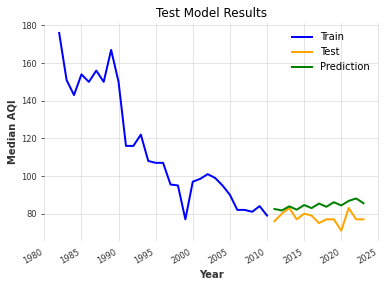

In [15]:
#Plot the results
train_series.plot(label = "Train", color = "blue")
test_series.plot(label = "Test", color = "orange")
prediction.plot(label = "Prediction", color = "green")
plt.ylabel("Median AQI")
plt.title("Test Model Results");

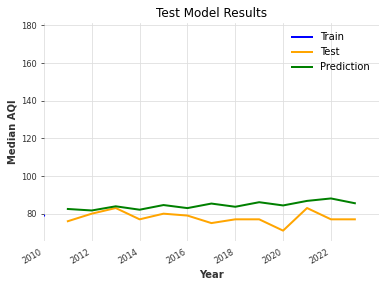

In [16]:
#Plot the results
date_range = [pd.to_datetime("2009-12-31", format = "%Y-%m-%d"), pd.to_datetime("2023-12-31", format = "%Y-%m-%d")]
train_series.plot(label = "Train", color = "blue")
test_series.plot(label = "Test", color = "orange")
prediction.plot(label = "Prediction", color = "green", xlim = date_range)
plt.ylabel("Median AQI")
plt.title("Test Model Results");

## Evaluation

In [17]:
#View the results numerically
#Mean Absolute Error
mae_value = metrics.mae(test_series,prediction)

In [18]:
#Mean Squared Error
mse_value = metrics.mse(test_series,prediction)

In [19]:
#Root Mean Squared Error
rmse_value = metrics.rmse(test_series,prediction)

In [20]:
#Create a dataframe to store values
evaluation_df = pd.DataFrame({
    "MAE" : [mae_value],
    "MSE" : [mse_value],
    "RMSE" : [rmse_value]
})

In [21]:
#Rotate the dataframe and rename the first column
evaluation_df = evaluation_df.transpose().rename(columns = {0:"Score"})

In [22]:
evaluation_df

,Score
MAE,6.593253
MSE,56.385023
RMSE,7.508996


## Forecasting

### Single County

In [23]:
#Convert dataframe into a list of timeseries
county_ts = TimeSeries.from_group_dataframe(filtered_df,"County","Year", "AQI Median", fill_missing_dates=True, freq="Y")

In [24]:
#Initialize final model
final_model = NBEATSModel(input_chunk_length = 2, output_chunk_length = 2, n_epochs = 30)

In [25]:
#Fit the model with the list of timeseries
final_model.fit(county_ts, verbose = True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 6.0 M 
---------------------------------------------------
6.0 M     Trainable params
1.3 K     Non-trainable params
6.0 M     Total params
48.177    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [26]:
#Create a function to predict and plot a single county
def plot_and_forecast(county, n = 5):
    forecast_county_df = filtered_df.groupby("County").get_group(county)
    series_for_forecasting = TimeSeries.from_dataframe(forecast_county_df, "Year", "AQI Median")
    forecast_result = final_model.predict(n, series = series_for_forecasting)
    series_for_forecasting.plot(label = "Historic", color = "black")
    forecast_result.plot(label = "Forecast", color = "blue")
    plt.ylabel("AQI Median");
    plt.title(county + " Forecasting")
    return forecast_result

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

<TimeSeries (DataArray) (Year: 5, component: 1, sample: 1)>
array([[[76.39279254]],

       [[74.83472883]],

       [[74.77792426]],

       [[74.27631234]],

       [[72.8023754 ]]])
Coordinates:
  * Year       (Year) datetime64[ns] 2023-12-31 2024-12-31 ... 2027-12-31
  * component  (component) object 'AQI Median'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

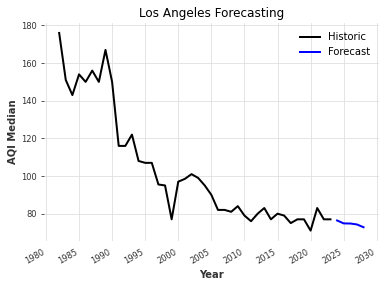

In [27]:
plot_and_forecast("Los Angeles")

### Multiple Counties

In [28]:
#Create a forecasting function to be used in a loop
def forecast_county(county, n = 5):
    forecast_county_df = filtered_df.groupby("County").get_group(county)
    series_for_forecasting = TimeSeries.from_dataframe(forecast_county_df, "Year", "AQI Median")
    forecast_result = final_model.predict(n, series = series_for_forecasting)
    return forecast_result

In [29]:
#Create a list of counties
county_list = filtered_df["County"].unique().tolist()

In [30]:
#Create a dataframe to store the list of counties and their forecasted values
forecasted_df = pd.DataFrame()

In [31]:
#Loop to forecast and store future multiple counties
for county in county_list:
    forecast_ahead = 5
    ts_result = forecast_county(county, forecast_ahead)
    df_result = TimeSeries.pd_dataframe(ts_result)
    county_name_list = []
    for i in range(0,(forecast_ahead)):
        county_name_list.append(county)
    df_result["County"] = county_name_list
    forecasted_df = pd.concat((forecasted_df,df_result))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [32]:
#Round AQI values
forecasted_df["AQI Median"] = forecasted_df["AQI Median"].round()

In [33]:
forecasted_df.head()

component,AQI Median,County
Year,,
2023-12-31,43.0,Alameda
2024-12-31,43.0,Alameda
2025-12-31,44.0,Alameda
2026-12-31,44.0,Alameda
2027-12-31,44.0,Alameda


In [34]:
#Combine filtered dataframe and forecasted dataframe
filtered_df = filtered_df.set_index("Year")
forecasted_df = pd.concat((filtered_df, forecasted_df))
forecasted_df.groupby("County").get_group("Alameda")

,County,AQI Median
Year,,
1981-12-31,Alameda,43.0
1982-12-31,Alameda,39.0
1983-12-31,Alameda,38.0
1984-12-31,Alameda,42.0
1985-12-31,Alameda,47.0
1986-12-31,Alameda,44.0
1987-12-31,Alameda,40.0
1988-12-31,Alameda,47.0
1989-12-31,Alameda,44.0


In [35]:
#Export to CSV
forecasted_df.to_csv("Forescasted_AQI_Dataset.csv")